In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.colab import files

# This will prompt you to upload the kaggle.json file
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c playground-series-s5e5
!unzip playground-series-s5e5.zip -d ./data
!ls ./data

  0% 0.00/12.5M [00:00<?, ?B/s]
100% 12.5M/12.5M [00:00<00:00, 676MB/s]
Archive:  playground-series-s5e5.zip
  inflating: ./data/sample_submission.csv  
  inflating: ./data/test.csv         
  inflating: ./data/train.csv        
sample_submission.csv  test.csv  train.csv


In [4]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.describe()
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


<Axes: xlabel='Calories', ylabel='Count'>

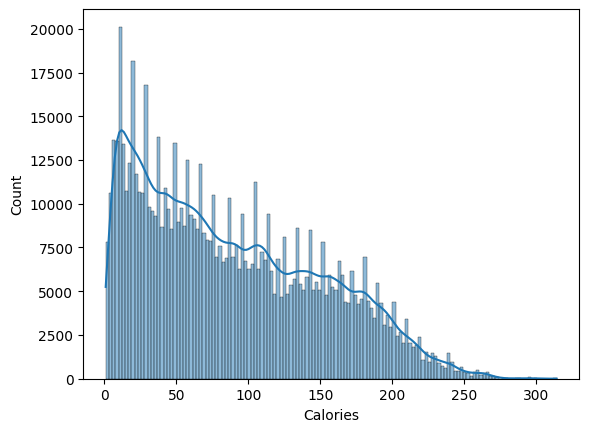

In [5]:
sns.histplot(train_df['Calories'],kde=True)

In [6]:
''' train_df['Sex'].replace({'female': 0, 'male':1}, inplace=True)
test_df['Sex'].replace({'female': 0, 'male':1}, inplace=True)
train_df.head()'''

" train_df['Sex'].replace({'female': 0, 'male':1}, inplace=True)\ntest_df['Sex'].replace({'female': 0, 'male':1}, inplace=True)\ntrain_df.head()"

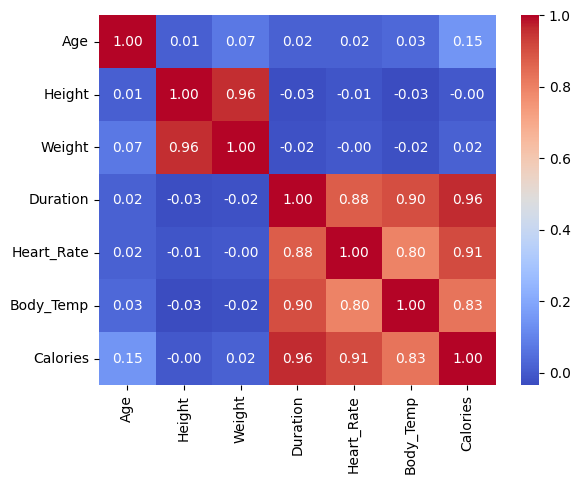

In [7]:
features = [col for col in train_df.columns if col not in ['Sex','id', 'Calories']]
num_features = len(features)
features_for_map = features.copy()
features_for_map.append('Calories')
correlation_map = train_df[features_for_map].corr()

sns.heatmap(correlation_map, cmap='coolwarm', annot=True,fmt='.2f')
plt.show()

In [8]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [9]:
train_df.drop(['id'],axis=1, inplace=True)
test_df.drop(['id'],axis=1, inplace=True)

In [10]:
X = train_df.drop(['Calories'],axis=1)
y = train_df['Calories']

X = pd.get_dummies(X, columns=['Sex'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((600000, 8), (150000, 8), (600000,), (150000,))

In [12]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [13]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [14]:
!pip install optuna-integration[lightgbm]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.2 MB/s eta 0:00:00


In [15]:
import optuna.integration.lightgbm as lgb_optuna
from sklearn.model_selection import KFold

In [18]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "feature_pre_filter": False,
    "early_stopping_rounds": 50,
    "device_type": "gpu",
    "random_state": 42
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

tuner = lgb_optuna.LightGBMTunerCV(
    params=params,
    train_set=train_data,
    num_boost_round=10000,
    folds=kf,
    return_cvbooster=True
)


[I 2025-05-27 04:17:41,301] A new study created in memory with name: no-name-370685c3-a9a4-4618-a5f6-d15ba9a2e166


In [ ]:
tuner.run()

print("Best parameters:")
print(tuner.best_params)

print("Best CV score:")
print(tuner.best_score)


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(

feature_fraction, val_score: 3.612856:  14%|#4        | 1/7 [01:30<09:05, 90.89s/it][I 2025-05-27 04:19:13,895] Trial 0 finished with value: 3.612856185040374 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 3.612856185040374.

feature_fraction, val_score: 3.612856:  14%|#4        | 1/7 [01:30<09:05, 90.89s/it]/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(

feature_fraction, val_score: 3.595322:  29%|##8       | 2/7 [03:02<07:35, 91.09s/it][I 2025-05-27 04:20:45,126] Trial 1 finished with value: 3.595321583589797 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 3.595321583589797.

feature_fraction, val_score: 3.595322:  29%|